In [1]:
import sys
from pathlib import Path
project_root = Path().cwd().resolve().parent
sys.path.insert(0, str(project_root))

In [2]:
import sqlite3

import os, argparse, path_config, shutil
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from loguru import logger

import torch
from torch_geometric.utils import to_networkx, k_hop_subgraph
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

from graph._multimodal_model_bilstm.GAT_explanation import GATJKClassifier as BiLSTMV2GAT
from graph.multimodal_topic_bilstm_proxy.dataset_explanation import make_graph as TopicProxyBiLSTM_make_graph

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
logger.remove()
logger.add(
  sys.stdout,
  colorize=True,
  format="<green>{time:HH:mm:ss}</green> | <level>{level: <8}</level> | <level>{message}</level>",
)

V2_MODEL = {
  'multimodal_topic_bilstm_proxy':BiLSTMV2GAT
}

MAKE_GRAPH = {
  'multimodal_topic_bilstm_proxy':TopicProxyBiLSTM_make_graph
}

In [10]:
def fetch_from_db(db_path):
  con = sqlite3.connect(db_path)
  cursor = con.cursor()
  cursor.execute('''
    SELECT param_name, param_value 
    FROM trial_params
    WHERE trial_id = (
      SELECT trial_id
      FROM trial_values
      ORDER BY value DESC
      LIMIT 1
    );
  ''')
  best_hyperparams_list = cursor.fetchall()
  best_hyperparams_dict = {}

  for k, v in best_hyperparams_list:
    if k not in ['batch_size', 'focal_alpha', 'focal_gamma', 'lr', 'optimizer', 'weight_decay']:
      if k in ['use_text_proj', 'use_attention']:
        best_hyperparams_dict[k] = True if v==0.0 else False
      elif k in ['num_layers', 'bilstm_num_layers']:
        best_hyperparams_dict[k] = int(v)
      else:
        best_hyperparams_dict[k] = v

  cursor.execute('''
    SELECT value
    FROM trial_values
    ORDER BY value DESC
    LIMIT 1
  ''')
  best_f1 = cursor.fetchone()[0]
  
  return best_hyperparams_dict, best_f1

In [11]:
model_dir = 'checkpoints_optuna'
model_dir_ = 'multimodal_topic_bilstm_proxy_v2'
save_dir = 'graph_visualization'
save_dir_ = 'multimodal_topic_bilstm_proxy_v2_id_405_ipynb'
id = 405
mode = 'multimodal_topic_bilstm_proxy'
version = 2

best_model_path = os.path.join(path_config.ROOT_DIR, model_dir, model_dir_, 'best_model.pth')
db_path = os.path.join(path_config.ROOT_DIR, model_dir, model_dir_, 'logs', 'optuna_study.db')
assert os.path.exists(best_model_path) and os.path.exists(db_path), logger.error("Model path is wrong. Try again.")

In [12]:
logger.info(f"Processing data (Mode: {mode}, Id: {id})")

if "multimodal" in mode:
  logger.info(f"Doing with multimodal mode")
  graphs, dim_list, extras = MAKE_GRAPH[mode](
    ids = [id],
    labels = [1],                   # Temporary Label
    model_name = 'sentence-transformers/all-MiniLM-L6-v2',
    use_summary_node = True,
    t_t_connect = False,
    v_a_connect = False,
    explanation = True
  )

  t_dim = dim_list[0]
  v_dim = dim_list[1]
  a_dim = dim_list[2]

else:
  logger.info(f"Doing with non-multimodal mode")
  graphs, dim_list, extras = MAKE_GRAPH[mode](
    ids = [id],
    labels = 1,                   # Temporary Label
    model_name = 'sentence-transformers/all-MiniLM-L6-v2',
    use_summary_node = True,
    t_t_connect = False,
    explanation = True
  )

  t_dim = dim_list[0]
  if 'bimodal' in mode:
    v_dim = dim_list[1]

23:34:30 | INFO     | Processing data (Mode: multimodal_topic_bilstm_proxy, Id: 405)
23:34:30 | INFO     | Doing with multimodal mode
23:34:30 | INFO     | Getting your model
23:34:33 | INFO     | Model loaded
23:34:33 | INFO     | Switching CSV into Graphs


Dataframe -> Graph: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


In [13]:
topic_node_id, utterances, vision_input, audio_input = extras

best_hyperparams_dict, best_f1 = fetch_from_db(db_path)

logger.info(f"Best Params")
for k, v in best_hyperparams_dict.items():
  logger.info(f"  - {k}: {v}")
logger.info(f"=> F1-score: {best_f1}")

23:34:35 | INFO     | Best Params
23:34:35 | INFO     |   - a_dropout: 0.39294858998728843
23:34:35 | INFO     |   - bilstm_num_layers: 2
23:34:35 | INFO     |   - g_dropout: 0.24654580705928375
23:34:35 | INFO     |   - num_layers: 3
23:34:35 | INFO     |   - t_dropout: 0.25237807640094945
23:34:35 | INFO     |   - use_attention: True
23:34:35 | INFO     |   - use_text_proj: False
23:34:35 | INFO     |   - v_dropout: 0.3430548105111857
23:34:35 | INFO     | => F1-score: 0.7586206896551724


In [14]:
logger.info("==============================")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Loading your model (Device: {device})")

assert version in [1,2], logger.error("Version should be int type 1 or 2")

if version == 2:
  model_dict = V2_MODEL

dropout_dict = {
  'text_dropout':best_hyperparams_dict.get('t_dropout', 0.0),
  'graph_dropout':best_hyperparams_dict.get('g_dropout', 0.0),
  'vision_dropout':best_hyperparams_dict.get('v_dropout', 0.0),
  'audio_dropout':best_hyperparams_dict.get('a_dropout', 0.0)
}


model = model_dict[mode](
  text_dim=t_dim,
  vision_dim=v_dim,
  audio_dim=a_dim,
  hidden_channels=256 if best_hyperparams_dict['use_text_proj'] else t_dim,
  num_layers=best_hyperparams_dict['num_layers'],
  bilstm_num_layers=best_hyperparams_dict['bilstm_num_layers'],
  num_classes=2,
  dropout_dict=dropout_dict,
  heads=8,
  use_attention=best_hyperparams_dict['use_attention'],
  use_summary_node=True,
  use_text_proj=best_hyperparams_dict['use_text_proj']
).to(device)

best_model_state_dict = torch.load(best_model_path)
model.load_state_dict(best_model_state_dict)

23:34:36 | INFO     | ==============================
23:34:36 | INFO     | Loading your model (Device: cuda)


<All keys matched successfully>

In [16]:
sample_loader = DataLoader(graphs)

model.eval()
with torch.no_grad():
  for data in sample_loader:
    data = data.to(device)
    result, x, flat_node_types = model(data, explanation=True)
    x = x.cpu()

In [17]:
topic_node_id

{'개인 특성 및 경험': 0, '대인 관계 및 가족': 1, '생활 환경 및 취미': 2, '심리 상태 및 감정': 3}

In [18]:
topic_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'topic']
text_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'transcription']
proxy_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'proxy']
vision_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'vision']
audio_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'audio']

In [19]:
source_indices = graphs[0].edge_index[0].numpy()
target_indices = graphs[0].edge_index[1].numpy()

In [20]:
utterances, vision_input, audio_input = np.array(utterances), np.array(vision_input), np.array(audio_input)

In [21]:
# For the fist topic
topic_target_indices = np.where(target_indices==topic_indices[1])                         # extract index of target edge_index where target is the certain topic node
text_source_ids = source_indices[topic_target_indices]                                    # extract text node ids from source edge_index
text_valid_ids = text_source_ids[text_source_ids>len(topic_indices)]                      # delete topic node ids
topic_text_indices = np.where(np.isin(text_indices, text_valid_ids)==True)                # extract text(utterance) index from text indices
topic_utterances = utterances[topic_text_indices]

text_target_indices = np.where(np.isin(target_indices, text_valid_ids)==True)             # extract index of target edge_index where target is the text from first topic node
proxy_source_ids = source_indices[text_target_indices]                                    # extract proxy node ids from source edge_index

proxy_target_indices = np.where(np.isin(target_indices, proxy_source_ids)==True)          # extract index of target edge_index where target is the proxy from text
vision_audio_source_ids = source_indices[proxy_target_indices]                            # extract vision/audio node ids from source edge_index
topic_vision_indices = np.where(np.isin(vision_indices, vision_audio_source_ids)==True)   # extract vision index from vision indices
topic_audio_indices = np.where(np.isin(audio_indices, vision_audio_source_ids)==True)     # extract audio index from vision indices
topic_vision = vision_input[topic_vision_indices] 
topic_audio = vision_input[topic_audio_indices]

In [22]:
topic_node_dict = {v+1:str(k) for k,v in topic_node_id.items()}

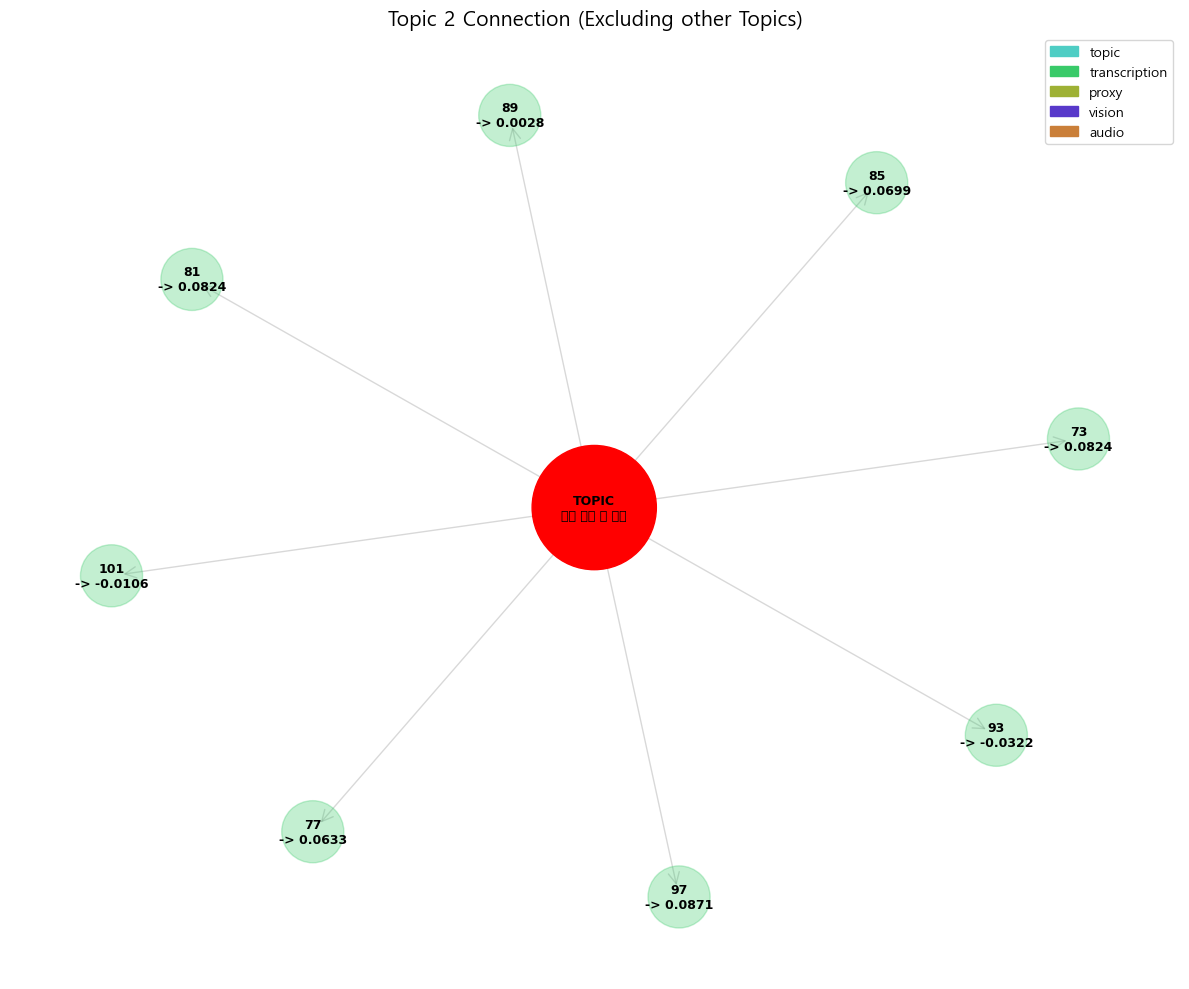

In [24]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

def visualize_topic_specific_graph(data, target_topic, all_topics, num_hops=1):
  exclude_topics = [t for t in all_topics if t != target_topic]
  edge_index = data.edge_index
  device = edge_index.device
  
  mask = ~torch.isin(edge_index[0], torch.tensor(exclude_topics).to(device)) & \
          ~torch.isin(edge_index[1], torch.tensor(exclude_topics).to(device))
  filtered_edge_index = edge_index[:, mask]

  subset, new_edge_index, mapping, edge_mask = k_hop_subgraph(
    target_topic, num_hops, filtered_edge_index, relabel_nodes=False
  )

  subset_x = data.x[subset]
  target_vec = data.x[target_topic].unsqueeze(0)
  
  # 코사인 유사도 계산
  similarities = F.cosine_similarity(target_vec, subset_x).cpu().detach().numpy()
  
  subset_node_types = np.array(data.node_types)[subset.cpu().numpy()]

  # 4. NetworkX 그래프 생성 및 속성 매핑
  G = nx.Graph()
  G.add_nodes_from(subset.tolist())
  G.add_edges_from(new_edge_index.t().tolist())

  node_labels = {}
  node_colors = []
  node_sizes = []
  node_values = [] # Alpha 값으로 활용
  
  color_map = {
    'topic': '#4ECDC4', 
    'transcription': "#39CA69",
    'proxy': "#9EB135",
    'vision': "#5839CA",
    'audio': "#CA7F39",
  }

  scale_factor = 7500

  for i, node_idx in enumerate(subset.tolist()):
    node_type = subset_node_types[i]
    sim_score = similarities[i]
    
    if node_idx == target_topic:
      node_labels[node_idx] = f"TOPIC\n{topic_node_dict.get(node_idx)}"
      node_colors.append('red') # 타겟 토픽은 강조
      node_sizes.append(8000)
      node_values.append(1.0)
    else:
      if node_type == 'transcription': 
        node_labels[node_idx] = f"{node_idx}\n-> {sim_score:.4f}"
      else:
        node_labels[node_idx] = f"{node_idx}"
      
      node_colors.append(color_map.get(node_type, 'skyblue'))
      node_sizes.append(max(2000, sim_score * scale_factor))
      node_values.append(max(0.3, sim_score))

  # 5. 시각화
  plt.figure(figsize=(12, 10))
  pos = nx.spring_layout(G, k=0.5, seed=42)
  
  # 노드 그리기
  nx.draw_networkx_nodes(G, pos,
                        node_color=node_colors,
                        node_size=node_sizes,
                        alpha=node_values)
  
  # 엣지 그리기
  nx.draw_networkx_edges(G, pos, edge_color='gray',
                        arrows=True, arrowstyle='->', arrowsize=20,
                        width=1.0, alpha=0.3)
  
  # 라벨 그리기
  nx.draw_networkx_labels(G, pos,
                        labels=node_labels,
                        font_size=9,
                        font_weight='bold')

  # 범례 설정
  legend_elements = [mpatches.Patch(color=c, label=t) for t, c in color_map.items()]
  plt.legend(handles=legend_elements, loc='upper right')
  
  plt.title(f"Topic {target_topic} Connection (Excluding other Topics)", fontsize=15)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

visualize_topic_specific_graph(graphs[0], 2, [1,2,3,4], num_hops=1)

In [25]:
text_valid_ids

array([ 73,  77,  81,  85,  89,  93,  97, 101], dtype=int64)

In [26]:
topic_utterances

array(["hmprobably with my. husband. and. i can't remember at the moment what it was about. ",
       'um well when you say my family do you meanmy  family from childhood or my current family. ',
       "okay well i guess my current family comes to mind i i have two daughtersand. my relationship's pretty good it's okay with them but they're teenagers which uh. you know. going they're going through a lot of hormones and. um. they can be kinda bitchy <laughter> and. ",
       "and um but i have hoped that you know they'll grow out of that and soon someday we'll have a really good relationshipum and then there's the husband which. i i guess i could say soon to be ex husband hopefully soon  <laughter>. we need to get a divorce but we're still together. due to financial reasons. and yeah. ",
       "yeah so that that's not good thethe relationship with the husband but um. but since we have determined that we need to divorce. our our we don't expect anything out out of each other so we don't

In [35]:
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.explain import Explainer, GNNExplainer
from captum.attr import IntegratedGradients
from tqdm import tqdm
import time

"""
=============================================================================
GNN Explainer 진행 과정 모니터링 버전
=============================================================================
"""

class ProgressGNNExplainer(GNNExplainer):
    """진행 상황을 출력하고, 마스크 초기화 안전장치를 포함한 GNN Explainer"""
    def __init__(self, epochs=100, **kwargs):
        super().__init__(epochs=epochs, **kwargs)
        self.loss_history = []
    
    def _train(self, model, x, edge_index, *, target, index, **kwargs):
        """학습 과정에서 진행 상황 출력 및 마스크 강제 초기화"""
        
        # [안전장치] 마스크가 생성되지 않은 경우 설정 강제 주입 및 초기화
        if self.node_mask is None and self.edge_mask is None:
            # print("⚠️ Masks not found. Forcing initialization...")
            if self.explainer_config.node_mask_type is None:
                self.explainer_config.node_mask_type = 'attributes' # 기본값: 노드 속성 마스킹
            if self.explainer_config.edge_mask_type is None:
                self.explainer_config.edge_mask_type = 'object'     # 기본값: 엣지 유무 마스킹
                
            self._initialize_masks(x, edge_index)
            # print("✅ Masks initialized manually.")

        # Optimizer 초기화 (마스크가 생성된 후 실행)
        parameters = []
        if self.node_mask is not None:
            parameters.append(self.node_mask)
        if self.edge_mask is not None:
            parameters.append(self.edge_mask)
            
        if len(parameters) == 0:
             # 그래도 없으면 진짜 오류
            raise ValueError("No masks to optimize! Check Explainer config.")

        self.optimizer = torch.optim.Adam(parameters, lr=self.lr)
        
        # 학습 루프
        pbar = tqdm(range(self.epochs), desc="Training GNN Explainer")
        for epoch in pbar:
            self.optimizer.zero_grad()
            h = model(x, edge_index, **kwargs)
            loss = self._loss(h, target)
            loss.backward()
            self.optimizer.step()
            
            self.loss_history.append(loss.item())
            if (epoch + 1) % 20 == 0:
                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})


class ModelWrapper(torch.nn.Module):
    def __init__(self, model, base_data):
        super().__init__()
        self.model = model
        self.base_data = base_data
    
    def forward(self, x, edge_index, **kwargs):
        data = self.base_data.clone()
        data.x = x
        data.edge_index = edge_index
        
        # 필수 속성들 복사
        data.x_vision = self.base_data.x_vision
        data.x_audio = self.base_data.x_audio
        data.vision_lengths = self.base_data.vision_lengths
        data.audio_lengths = self.base_data.audio_lengths
        data.node_types = self.base_data.node_types
        
        # ptr 속성 추가 (단일 그래프용)
        if not hasattr(data, 'ptr'):
            data.ptr = torch.tensor([0, data.x.size(0)], dtype=torch.long, device=x.device)
        
        # batch 속성 확인
        if not hasattr(data, 'batch'):
            data.batch = torch.zeros(data.x.size(0), dtype=torch.long, device=x.device)
        
        return self.model(data, explanation=False)


def explain_with_gnn_explainer_verbose(model, data, target_topic, all_topics, epochs=100):
    """
    진행 상황을 자세히 출력하는 GNN Explainer
    
    Args:
        model: 학습된 GNN 모델
        data: PyG Data 객체
        target_topic: 타겟 토픽 노드 ID
        all_topics: 모든 토픽 노드 리스트
        epochs: Explainer 학습 에폭 수
    """
    device = data.x.device
    model.eval()
    
    print(f"\n{'='*70}")
    print(f"🎯 Target Topic: {target_topic}")
    print(f"📊 Graph Info: {data.num_nodes} nodes, {data.num_edges} edges")
    print('='*70)
    
    # 배치 정보 추가
    if not hasattr(data, 'batch'):
        data.batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
    
    # ptr 속성 추가 (중요!)
    if not hasattr(data, 'ptr'):
        data.ptr = torch.tensor([0, data.x.size(0)], dtype=torch.long, device=device)
        print("✅ Added 'ptr' attribute for single graph")
    
    # 모델 래퍼 생성
    wrapped_model = ModelWrapper(model, data).to(device)
    
    try:
        start_time = time.time()
        
        # Progress GNN Explainer 사용
        explainer = Explainer(
            model=wrapped_model,
            algorithm=ProgressGNNExplainer(epochs=epochs),
            explanation_type='model',
            node_mask_type='attributes',
            edge_mask_type='object',
            model_config=dict(
                mode='binary_classification',
                task_level='graph',
                return_type='raw',
            ),
        )
        
        # 설명 생성
        print("\n⏳ Generating explanation...")
        explanation = explainer(data.x, data.edge_index, batch=data.batch)
        
        elapsed = time.time() - start_time
        print(f"\n⏱️  Total Time: {elapsed:.2f} seconds")
        
        # 결과 요약
        node_mask = explanation.node_mask.sum(dim=1).detach().cpu().numpy()
        edge_mask = explanation.edge_mask.detach().cpu().numpy()
        
        print("\n📈 Explanation Statistics:")
        print(f"  Node importance - Mean: {node_mask.mean():.4f}, Std: {node_mask.std():.4f}")
        print(f"  Edge importance - Mean: {edge_mask.mean():.4f}, Std: {edge_mask.std():.4f}")
        print(f"  Top node importance: {node_mask.max():.4f}")
        print(f"  Top edge importance: {edge_mask.max():.4f}")
        
        return explanation, explainer.algorithm.loss_history
        
    except Exception as e:
        print(f"\n❌ GNNExplainer failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None


def plot_loss_curve(loss_history):
    """GNN Explainer의 손실 곡선 시각화"""
    if loss_history is None or len(loss_history) == 0:
        return
    
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, linewidth=2, color='#4ECDC4')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('GNN Explainer Training Loss', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def compare_all_methods(model, data, target_topic, all_topics):
    """
    모든 설명 방법을 비교하고 시간 측정
    """
    device = data.x.device
    model.eval()
    
    results = {}
    timings = {}
    
    print(f"\n{'='*70}")
    print("🔬 COMPARING ALL EXPLANATION METHODS")
    print('='*70)
    
    # 1. SIMPLE
    print("\n[1/4] 🚀 SIMPLE (Input Feature Similarity)")
    start = time.time()
    node_attr, edge_attr = explain_simple(model, data, target_topic)
    timings['simple'] = time.time() - start
    results['simple'] = (node_attr, edge_attr, "SIMPLE")
    print(f"  ✅ Completed in {timings['simple']:.3f}s")
    
    # 2. COSINE
    print("\n[2/4] 🧮 COSINE (Model Embedding Similarity)")
    start = time.time()
    node_attr, edge_attr, _ = explain_with_model_embeddings(model, data, target_topic)
    timings['cosine'] = time.time() - start
    results['cosine'] = (node_attr, edge_attr, "COSINE")
    print(f"  ✅ Completed in {timings['cosine']:.3f}s")
    
    # 3. GRADIENT
    print("\n[3/4] 📉 GRADIENT (Captum IntegratedGradients)")
    start = time.time()
    try:
        node_attr, edge_attr, _ = explain_with_gradients(model, data, target_topic)
        timings['gradient'] = time.time() - start
        results['gradient'] = (node_attr, edge_attr, "GRADIENT")
        print(f"  ✅ Completed in {timings['gradient']:.3f}s")
    except Exception as e:
        print(f"  ❌ Failed: {e}")
        timings['gradient'] = None
    
    # 4. GNN_EXPLAINER
    print("\n[4/4] 🎯 GNN_EXPLAINER (Structure + Features)")
    start = time.time()
    explanation, loss_history = explain_with_gnn_explainer_verbose(
        model, data, target_topic, all_topics, epochs=100
    )
    timings['gnn'] = time.time() - start
    
    if explanation is not None:
        node_attr = explanation.node_mask.sum(dim=1).detach().cpu().numpy()
        edge_attr = explanation.edge_mask.detach().cpu().numpy()
        results['gnn'] = (node_attr, edge_attr, "GNN_EXPLAINER")
        
        # 손실 곡선 출력
        plot_loss_curve(loss_history)
    
    # 시간 비교
    print(f"\n{'='*70}")
    print("⏱️  EXECUTION TIME COMPARISON")
    print('='*70)
    for method, t in timings.items():
        if t is not None:
            print(f"  {method.upper():15s}: {t:6.3f}s")
    print('='*70)
    
    return results, timings


def explain_simple(model, data, target_topic):
    """간단한 입력 피처 기반 설명"""
    target_feature = data.x[target_topic].unsqueeze(0)
    node_attr = F.cosine_similarity(target_feature, data.x).cpu().numpy()
    
    edge_index = data.edge_index
    src_sim = node_attr[edge_index[0].cpu()]
    dst_sim = node_attr[edge_index[1].cpu()]
    edge_attr = (src_sim + dst_sim) / 2
    
    return node_attr, edge_attr


def explain_with_model_embeddings(model, data, target_topic):
    """모델 임베딩 기반 설명"""
    device = data.x.device
    model.eval()
    
    with torch.no_grad():
        x, edge_index = data.x, data.edge_index
        node_types = data.node_types
        
        # Text projection
        if hasattr(model, 'use_text_proj') and model.use_text_proj:
            x = model.text_proj(x)
        x = model.dropout_text(x)
        
        # Vision/Audio 처리 (GAT.py와 동일하게)
        flat_node_types = []
        if isinstance(node_types[0], list):
            for sublist in node_types: 
                flat_node_types.extend(sublist)
        else:
            flat_node_types = node_types
        
        vision_indices = [i for i, t in enumerate(flat_node_types) if t == 'vision']
        audio_indices = [i for i, t in enumerate(flat_node_types) if t == 'audio']
        
        # Vision LSTM
        if data.x_vision.size(0) > 0 and len(vision_indices) > 0:
            h_vision, _ = model.vision_lstm(data.x_vision, data.vision_lengths)
            if len(vision_indices) == h_vision.size(0):
                x[vision_indices] = h_vision.to(x.dtype)
        
        # Audio LSTM
        if data.x_audio.size(0) > 0 and len(audio_indices) > 0:
            h_audio, _ = model.audio_lstm(data.x_audio, data.audio_lengths)
            if len(audio_indices) == h_audio.size(0):
                x[audio_indices] = h_audio.to(x.dtype)
        
        # GAT layers (num_layers에 따라)
        x = F.dropout(x, p=model.dropout_g, training=False)
        x = model.conv1(x, edge_index)
        x = model.norm1(x)
        x = F.elu(x)
        
        if model.num_layers >= 3:
            x_in = x
            x = F.dropout(x, p=model.dropout_g, training=False)
            x = model.conv2(x, edge_index)
            x = model.norm2(x + x_in) if hasattr(model, 'norm2') else x
            x = F.elu(x)
        
        if model.num_layers >= 4:
            x_in = x
            x = F.dropout(x, p=model.dropout_g, training=False)
            x = model.conv3(x, edge_index)
            x = model.norm3(x + x_in) if hasattr(model, 'norm3') else x
            x = F.elu(x)
        
        x = F.dropout(x, p=model.dropout_g, training=False)
        x = model.conv4(x, edge_index)
        x = model.norm4(x)
        
        target_emb = x[target_topic].unsqueeze(0)
        node_attr = F.cosine_similarity(target_emb, x).cpu().numpy()
    
    edge_index = data.edge_index
    src_sim = node_attr[edge_index[0].cpu()]
    dst_sim = node_attr[edge_index[1].cpu()]
    edge_attr = (src_sim + dst_sim) / 2
    
    return node_attr, edge_attr, "Model Embedding"


def explain_with_gradients(model, data, target_topic):
    """Gradient 기반 설명"""
    device = data.x.device
    model.eval()
    
    def forward_func(node_features):
        data_copy = data.clone()
        data_copy.x = node_features
        
        # 필수 속성 복사
        data_copy.x_vision = data.x_vision
        data_copy.x_audio = data.x_audio
        data_copy.vision_lengths = data.vision_lengths
        data_copy.audio_lengths = data.audio_lengths
        data_copy.node_types = data.node_types
        
        # batch와 ptr 추가
        if not hasattr(data_copy, 'batch'):
            data_copy.batch = torch.zeros(data_copy.x.size(0), dtype=torch.long, device=device)
        if not hasattr(data_copy, 'ptr'):
            data_copy.ptr = torch.tensor([0, data_copy.x.size(0)], dtype=torch.long, device=device)
        
        out = model(data_copy, explanation=False)
        if out.dim() == 1:
            out = out.unsqueeze(-1)
        return out

    ig = IntegratedGradients(forward_func)
    baseline_x = torch.zeros_like(data.x)
    
    attributions = ig.attribute(
        data.x,
        baselines=baseline_x,
        target=0,
        n_steps=50,
        internal_batch_size=1
    )
    
    node_attr = attributions.abs().sum(dim=1).cpu().detach().numpy()
    target_importance = node_attr[target_topic]
    node_attr = node_attr / (target_importance + 1e-8)
    
    edge_index = data.edge_index
    src_imp = node_attr[edge_index[0].cpu()]
    dst_imp = node_attr[edge_index[1].cpu()]
    edge_attr = (src_imp + dst_imp) / 2
    
    return node_attr, edge_attr, "Gradient"


# ============= 사용 예시 =============
"""
# 1. 단일 방법 (GNN Explainer만)
explanation, loss_history = explain_with_gnn_explainer_verbose(
    model=model,
    data=graphs[0],
    target_topic=2,
    all_topics=[1, 2, 3, 4],
    epochs=100  # 에폭 수 조절 가능
)

# 2. 모든 방법 비교 (시간 측정 포함)
results, timings = compare_all_methods(
    model=model,
    data=graphs[0],
    target_topic=2,
    all_topics=[1, 2, 3, 4]
)

# 3. 특정 에폭으로 빠른 테스트
explanation, loss_history = explain_with_gnn_explainer_verbose(
    model=model,
    data=graphs[0],
    target_topic=2,
    all_topics=[1, 2, 3, 4],
    epochs=20  # 빠른 테스트용
)
"""

'\n# 1. 단일 방법 (GNN Explainer만)\nexplanation, loss_history = explain_with_gnn_explainer_verbose(\n    model=model,\n    data=graphs[0],\n    target_topic=2,\n    all_topics=[1, 2, 3, 4],\n    epochs=100  # 에폭 수 조절 가능\n)\n\n# 2. 모든 방법 비교 (시간 측정 포함)\nresults, timings = compare_all_methods(\n    model=model,\n    data=graphs[0],\n    target_topic=2,\n    all_topics=[1, 2, 3, 4]\n)\n\n# 3. 특정 에폭으로 빠른 테스트\nexplanation, loss_history = explain_with_gnn_explainer_verbose(\n    model=model,\n    data=graphs[0],\n    target_topic=2,\n    all_topics=[1, 2, 3, 4],\n    epochs=20  # 빠른 테스트용\n)\n'

In [49]:
def visualize_topic_subgraph(data, node_attr, edge_attr, target_topic_idx, title="Topic Subgraph Visualization"):
    """
    특정 토픽과 연결된 하위 노드들(Text -> Proxy -> Vision/Audio)만 추출하여
    계층적으로 시각화하고, 노드 ID와 중요도 수치를 표시합니다.
    """
    # ---------------------------------------------------------
    # 1. 서브그래프 노드 및 엣지 필터링 (계층적 탐색)
    # ---------------------------------------------------------
    edge_index = data.edge_index.cpu().numpy()
    src, dst = edge_index[0], edge_index[1]
    
    # 노드 타입 리스트 평탄화
    flat_node_types = []
    if isinstance(data.node_types[0], list):
        for sublist in data.node_types: flat_node_types.extend(sublist)
    else:
        flat_node_types = data.node_types
    flat_node_types = np.array(flat_node_types)

    # (1) Topic 노드 (Layer 0)
    nodes_layer_0 = [target_topic_idx]
    
    # (2) Connected Transcription 노드 찾기 (Layer 1)
    # Topic과 연결된 엣지 중, 상대방이 transcription인 것
    connected_edges_0 = np.where((src == target_topic_idx) | (dst == target_topic_idx))[0]
    nodes_layer_1 = []
    for idx in connected_edges_0:
        u, v = src[idx], dst[idx]
        neighbor = v if u == target_topic_idx else u
        if flat_node_types[neighbor] == 'transcription':
            nodes_layer_1.append(neighbor)
    nodes_layer_1 = list(set(nodes_layer_1))

    # (3) Connected Proxy 노드 찾기 (Layer 2)
    # Layer 1(Text) 노드들과 연결된 Proxy 찾기
    nodes_layer_2 = []
    if nodes_layer_1:
        connected_edges_1 = np.isin(src, nodes_layer_1) | np.isin(dst, nodes_layer_1)
        edge_indices_1 = np.where(connected_edges_1)[0]
        for idx in edge_indices_1:
            u, v = src[idx], dst[idx]
            # u가 Text면 v가 이웃, v가 Text면 u가 이웃
            neighbor = v if u in nodes_layer_1 else u
            if flat_node_types[neighbor] == 'proxy':
                nodes_layer_2.append(neighbor)
    nodes_layer_2 = list(set(nodes_layer_2))

    # (4) Connected Vision/Audio 노드 찾기 (Layer 3)
    nodes_layer_3 = []
    if nodes_layer_2:
        connected_edges_2 = np.isin(src, nodes_layer_2) | np.isin(dst, nodes_layer_2)
        edge_indices_2 = np.where(connected_edges_2)[0]
        for idx in edge_indices_2:
            u, v = src[idx], dst[idx]
            neighbor = v if u in nodes_layer_2 else u
            if flat_node_types[neighbor] in ['vision', 'audio']:
                nodes_layer_3.append(neighbor)
    nodes_layer_3 = list(set(nodes_layer_3))

    # 전체 서브그래프 노드 집합
    all_subgraph_nodes = set(nodes_layer_0 + nodes_layer_1 + nodes_layer_2 + nodes_layer_3)

    # ---------------------------------------------------------
    # 2. NetworkX 그래프 생성 및 속성 할당
    # ---------------------------------------------------------
    G = nx.DiGraph()
    
    color_map = {
        'summary': '#FF6B6B', 'topic': '#4ECDC4', 'transcription': '#45B7D1',
        'proxy': '#A0A0A0', 'vision': '#FFA07A', 'audio': '#98D8C8'
    }

    # 노드 추가
    for node_idx in all_subgraph_nodes:
        n_type = flat_node_types[node_idx]
        
        # 중요도 점수 (node_attr에서 가져옴)
        score = node_attr[node_idx] if node_attr is not None else 0.0
        
        # 레이어 정보 할당 (시각화 배치용)
        if node_idx in nodes_layer_0: layer = 0
        elif node_idx in nodes_layer_1: layer = 1
        elif node_idx in nodes_layer_2: layer = 2
        else: layer = 3
        
        # 라벨 포맷: "ID\n(0.xx)"
        label_text = f"{node_idx}\n({score:.3f})"
        
        G.add_node(node_idx, 
                   color=color_map.get(n_type, 'gray'),
                   layer=layer,
                   label=label_text,
                   size=3000 if layer==0 else 1500)

    # 엣지 추가 (서브그래프 노드끼리의 연결만)
    final_edges = []
    final_edge_colors = []
    final_edge_widths = []
    
    for i in range(len(src)):
        u, v = src[i], dst[i]
        if u in all_subgraph_nodes and v in all_subgraph_nodes:
            # 방향성 정리 (계층 위 -> 아래)
            # Layer가 작은 쪽에서 큰 쪽으로 화살표
            layer_u = G.nodes[u]['layer']
            layer_v = G.nodes[v]['layer']
            
            # 같은 레이어끼리는 연결 안 함 (깔끔함을 위해)
            if layer_u == layer_v: continue
            
            # 위에서 아래로 그리도록 source/target 조정
            source, target = (u, v) if layer_u < layer_v else (v, u)
            
            # 중복 엣지 방지
            if not G.has_edge(source, target):
                imp = edge_attr[i] if edge_attr is not None else 0.5
                
                # 엣지 스타일 계산
                width = 1 + 5 * imp  # 중요할수록 굵게
                alpha = max(0.2, imp) # 중요할수록 진하게
                
                G.add_edge(source, target)
                final_edges.append((source, target))
                final_edge_colors.append((0.5, 0.5, 0.5, alpha)) # RGBA Gray
                final_edge_widths.append(width)

    # ---------------------------------------------------------
    # 3. 시각화 (Multipartite Layout - 계층형)
    # ---------------------------------------------------------
    plt.figure(figsize=(14, 10))
    
    # 계층형 레이아웃 (Multipartite)
    pos = nx.multipartite_layout(G, subset_key="layer", align='horizontal')
    # 방향을 위(Topic) -> 아래(Audio)로 바꾸기 위해 y축 반전 조정은 multipartite가 자동으로 해줌
    # (기본적으로 layer 0이 왼쪽이나 위쪽으로 감)
    
    # 노드 그리기
    colors = [G.nodes[n]['color'] for n in G.nodes]
    sizes = [G.nodes[n]['size'] for n in G.nodes]
    
    # 노드 본체
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, edgecolors='black')
    
    # 노드 라벨 (ID + 점수)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_family='Malgun Gothic', font_weight='bold')
    
    # 엣지 그리기
    for i, edge in enumerate(final_edges):
        nx.draw_networkx_edges(G, pos, 
                               edgelist=[edge], 
                               width=final_edge_widths[i], 
                               edge_color=[final_edge_colors[i]],
                               arrowstyle='-', arrowsize=20)

    # 범례 및 타이틀
    legend_elements = [mpatches.Patch(color=c, label=l) for l, c in color_map.items()]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

00:10:06 | INFO     | Target Graph: 197 nodes, 208 edges
00:10:06 | INFO     | Target Topic Node Index: 2
00:10:06 | INFO     | Comparing all methods...

🔬 COMPARING ALL EXPLANATION METHODS

[1/4] 🚀 SIMPLE (Input Feature Similarity)
  ✅ Completed in 0.001s

[2/4] 🧮 COSINE (Model Embedding Similarity)
  ✅ Completed in 0.195s

[3/4] 📉 GRADIENT (Captum IntegratedGradients)
  ✅ Completed in 3.103s

[4/4] 🎯 GNN_EXPLAINER (Structure + Features)

🎯 Target Topic: 2
📊 Graph Info: 197 nodes, 208 edges

⏳ Generating explanation...


Training GNN Explainer: 100%|██████████| 100/100 [00:06<00:00, 14.61it/s, Loss=0.2973]


⏱️  Total Time: 6.90 seconds

📈 Explanation Statistics:
  Node importance - Mean: 191.9963, Std: 0.4803
  Edge importance - Mean: 0.5023, Std: 0.0249
  Top node importance: 193.5230
  Top edge importance: 0.5673


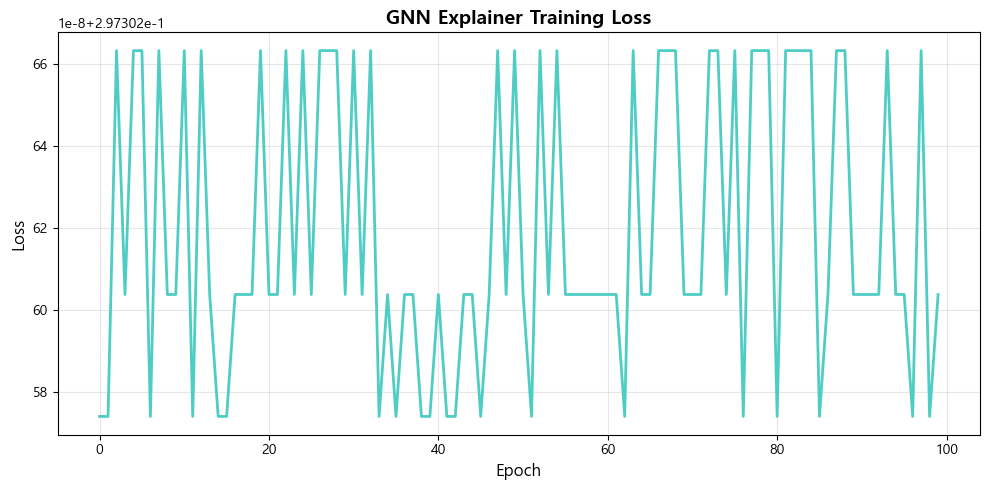


⏱️  EXECUTION TIME COMPARISON
  SIMPLE         :  0.001s
  COSINE         :  0.195s
  GRADIENT       :  3.103s
  GNN            :  6.903s

🎨 STARTING TOPIC-CENTERED VISUALIZATION FOR ALL METHODS

▶ Method: SIMPLE
  📷 Vision Importance | Avg: 0.1221, Max: 0.1475
  🎤 Audio Importance  | Avg: 0.1650, Max: 0.3003


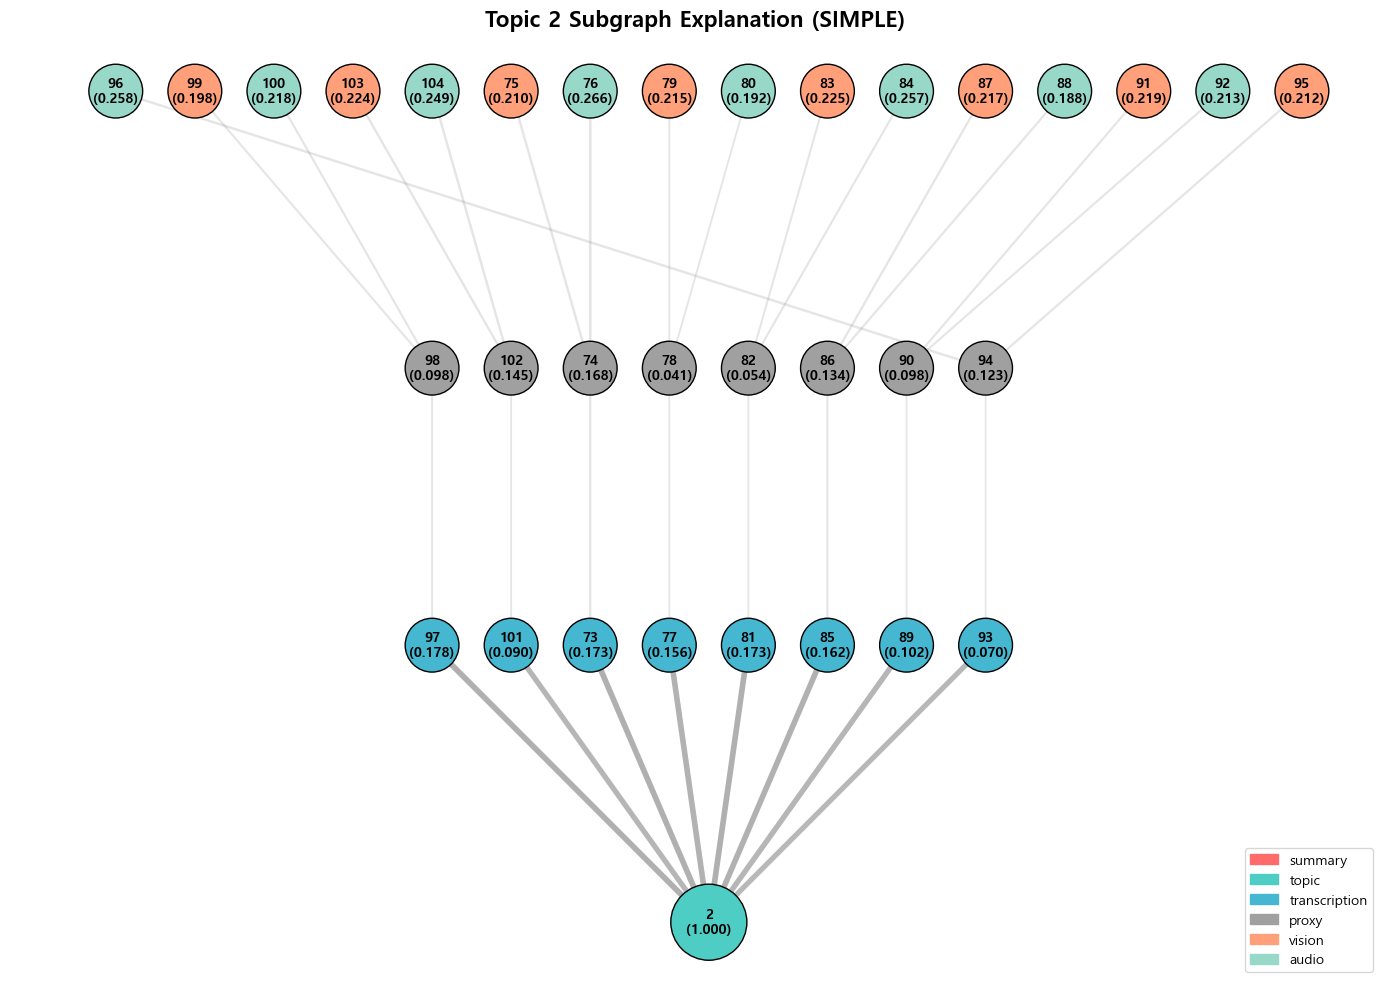

------------------------------------------------------------

▶ Method: COSINE
  📷 Vision Importance | Avg: -0.0979, Max: 0.6641
  🎤 Audio Importance  | Avg: -0.2515, Max: 0.5711


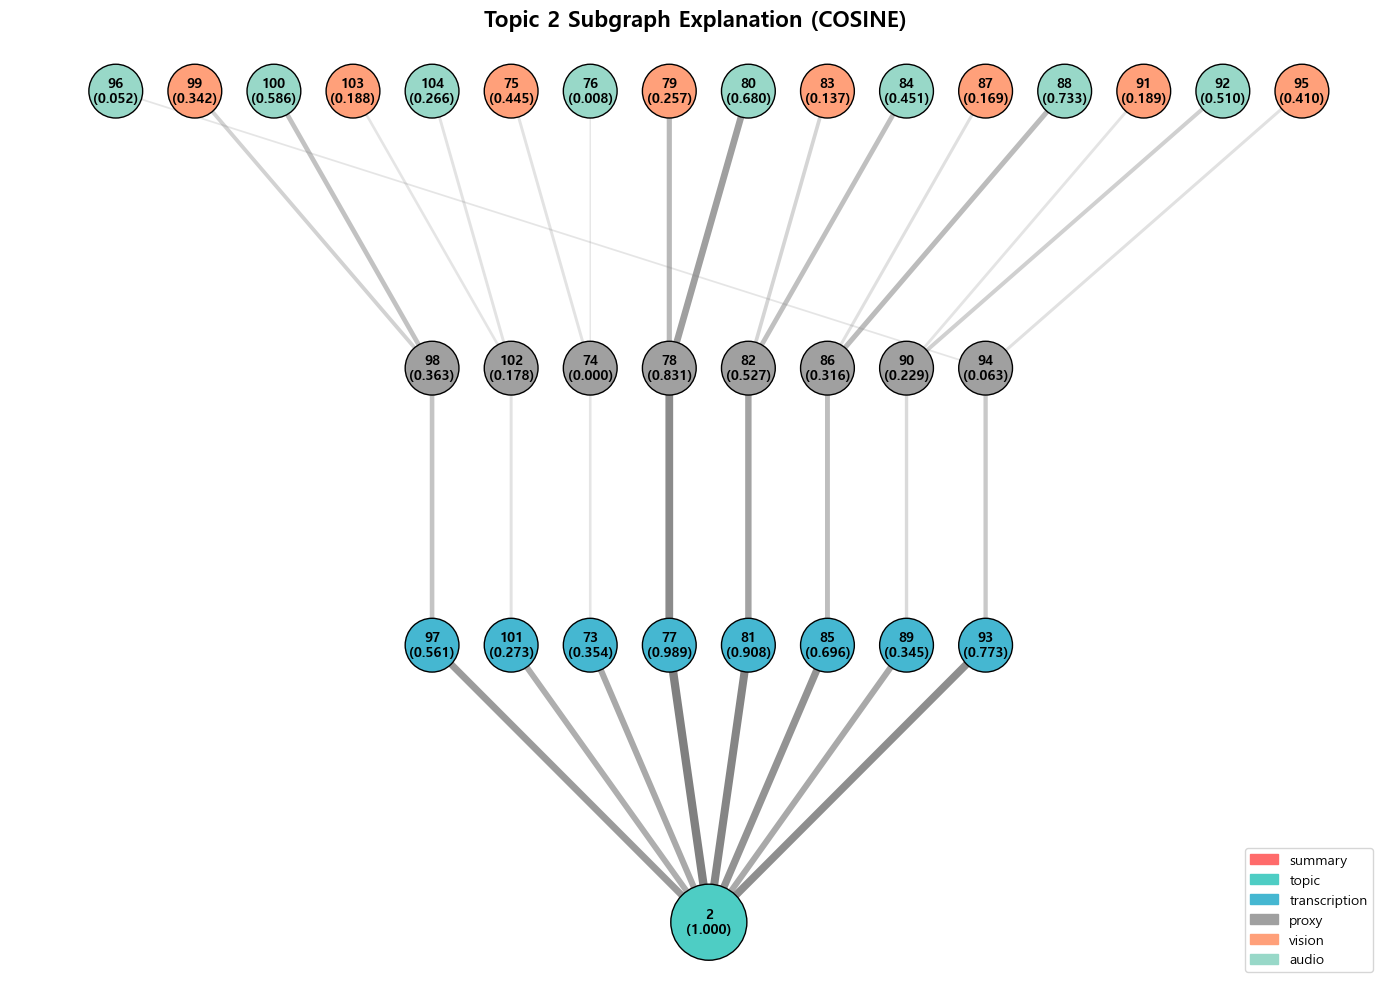

------------------------------------------------------------

▶ Method: GRADIENT
  📷 Vision Importance | Avg: 0.1552, Max: 0.3071
  🎤 Audio Importance  | Avg: 0.1638, Max: 0.3103


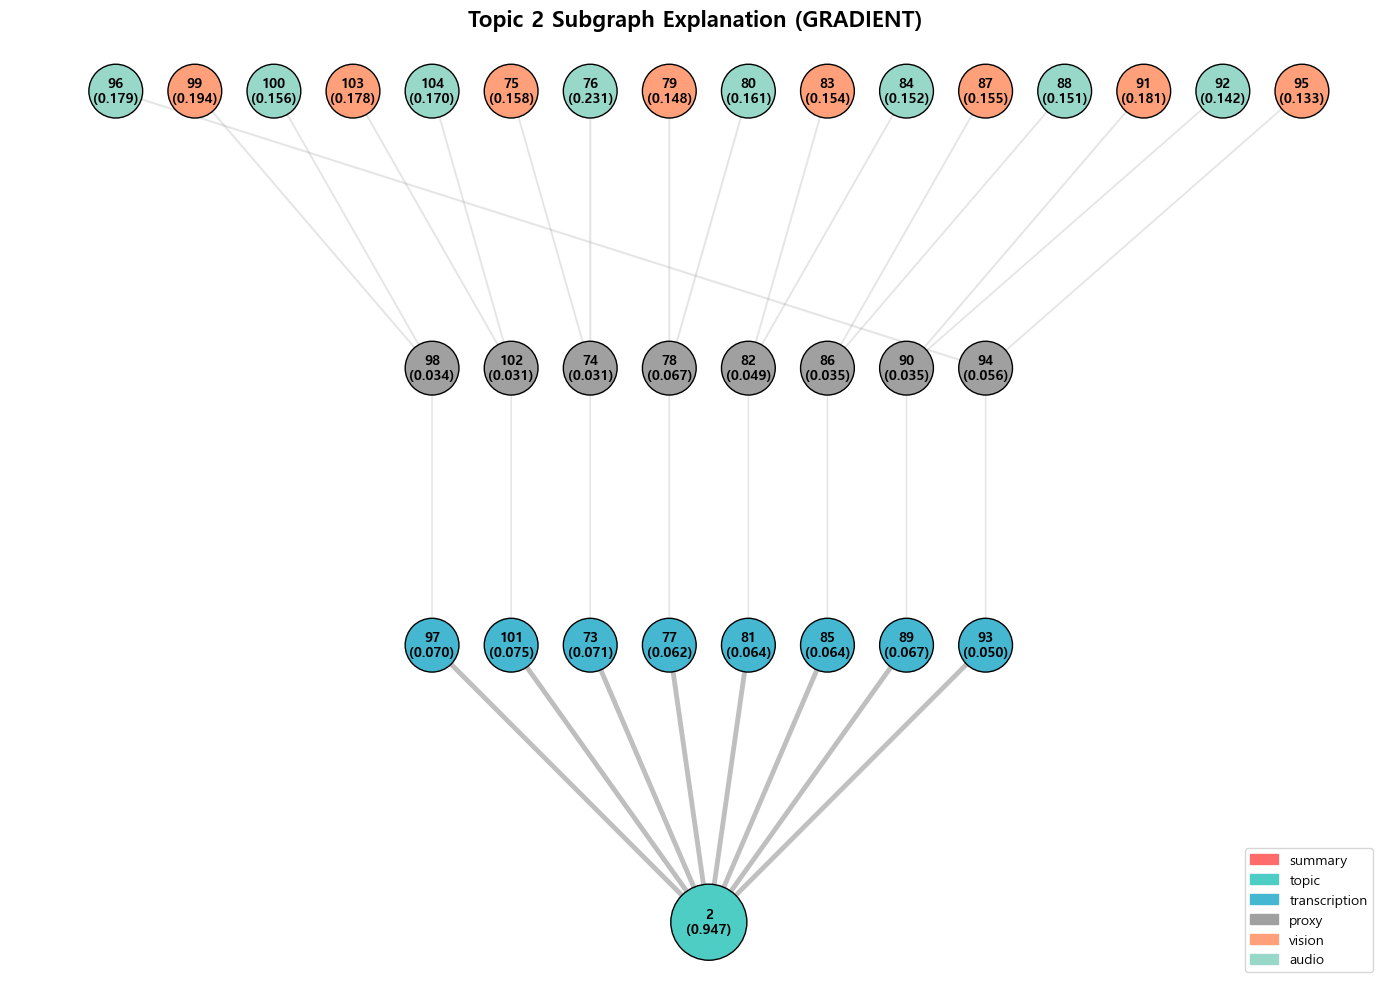

------------------------------------------------------------

▶ Method: GNN_EXPLAINER
  📷 Vision Importance | Avg: 191.9802, Max: 193.1931
  🎤 Audio Importance  | Avg: 192.0047, Max: 193.5230


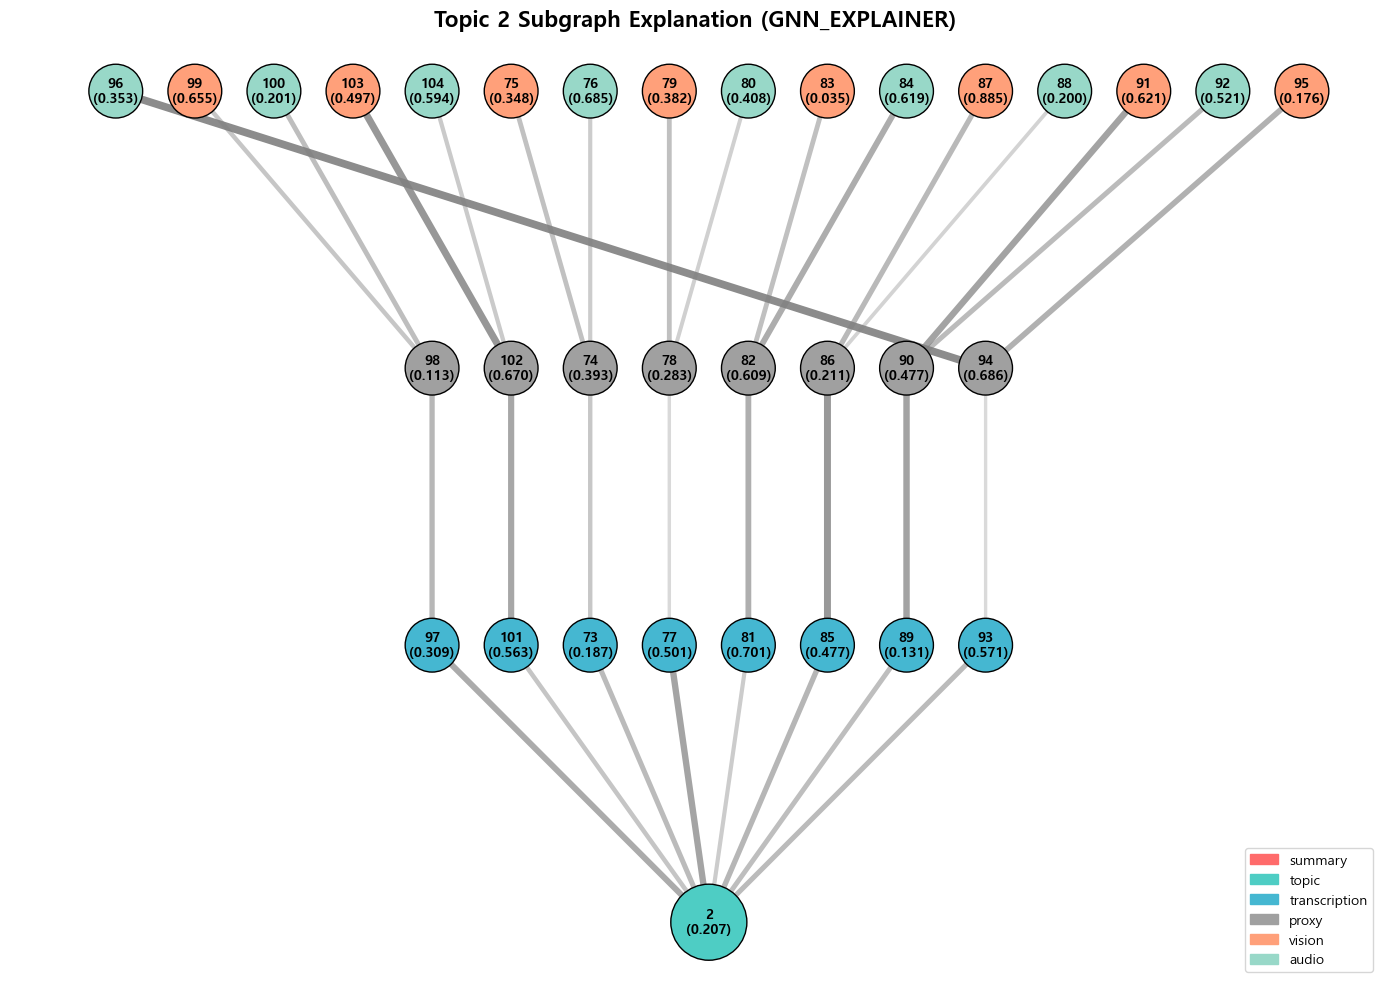

------------------------------------------------------------

✅ All visualizations completed.


In [50]:
# =============================================================================
# [최종 실행 코드] 모든 방법 실행 및 "토픽 중심 서브그래프" 시각화
# =============================================================================

# 1. 타겟 그래프 및 토픽 설정
target_graph = graphs[0].to(device)

# 'topic' 타입을 가진 노드들의 인덱스를 찾습니다.
all_topic_indices = [i for i, t in enumerate(target_graph.node_types) if t == 'topic']
target_topic_idx = all_topic_indices[1] # 2번째 토픽을 타겟으로 설정

logger.info(f"Target Graph: {target_graph.num_nodes} nodes, {target_graph.num_edges} edges")
logger.info(f"Target Topic Node Index: {target_topic_idx}")

# 2. 모든 설명 방법 실행 (결과 계산)
logger.info("Comparing all methods...")
results, timings = compare_all_methods(
   model=model,
   data=target_graph,
   target_topic=target_topic_idx,
   all_topics=all_topic_indices
)

print("\n" + "="*60)
print("🎨 STARTING TOPIC-CENTERED VISUALIZATION FOR ALL METHODS")
print("="*60)

# 3. 결과 반복문 -> "visualize_topic_subgraph" 함수 호출
for method_name, (node_attr, edge_attr, desc) in results.items():
    print(f"\n▶ Method: {desc}")
    
    # (1) 수치적 중요도 요약 출력 (Vision/Audio)
    vision_indices = [i for i, t in enumerate(target_graph.node_types) if t == 'vision']
    audio_indices = [i for i, t in enumerate(target_graph.node_types) if t == 'audio']
    
    if vision_indices:
        v_imp = node_attr[vision_indices]
        print(f"  📷 Vision Importance | Avg: {v_imp.mean():.4f}, Max: {v_imp.max():.4f}")
    else:
        print("  📷 Vision Importance | No Vision Nodes")
        
    if audio_indices:
        a_imp = node_attr[audio_indices]
        print(f"  🎤 Audio Importance  | Avg: {a_imp.mean():.4f}, Max: {a_imp.max():.4f}")
    else:
        print("  🎤 Audio Importance  | No Audio Nodes")

    # (2) [핵심 수정] 중요도 정규화 (0~1) -> 시각화 함수 호출
    # 시각화 함수가 색상/굵기를 잘 표현하도록 Min-Max 정규화를 수행합니다.
    if node_attr.max() != node_attr.min():
        norm_node_attr = (node_attr - node_attr.min()) / (node_attr.max() - node_attr.min() + 1e-9)
    else:
        norm_node_attr = node_attr

    if edge_attr is not None and edge_attr.max() != edge_attr.min():
        norm_edge_attr = (edge_attr - edge_attr.min()) / (edge_attr.max() - edge_attr.min() + 1e-9)
    else:
        norm_edge_attr = edge_attr

    # 계층형 서브그래프 시각화 호출
    visualize_topic_subgraph(
        data=target_graph,
        node_attr=norm_node_attr,
        edge_attr=norm_edge_attr,
        target_topic_idx=target_topic_idx,
        title=f"Topic {target_topic_idx} Subgraph Explanation ({desc})"
    )
    
    print("-" * 60)

print("\n✅ All visualizations completed.")

In [ ]:
print(text_valid_ids)
print(topic_utterances)

# 81, 85, 89, 93
# 결과
# 85번의 Vision node가 0.885로 중요한 요소 -> divorce를 말하는 당시 발화자의 표정, 시선, 얼굴 좌표 분석 필요
# 97번의 Audio node가 0.655로 중요한 요소 -> first husband를 말하는 당시 오디오 분석 필요
# 81번의 text node가 0.701로 중요한 요소 -> 실제 자녀들을 기르는 과정에서의 힘겨움을 이야기 함
# 73번의 text node는 0.187로 중요하지 않은 요소 -> 내담자의 감정/경험을 바탕으로 분석하는 우울증 분석에서 '기억이 나지 않는다'는 말은 결과에 큰 영향을 주지 않는다는 통상적인 상식과 일치

# 모델이 우울증 판별에 있어서 중요한 부분을 찾아내고, 이를 활용하여 임베딩을 업데이트하며 학습했다는 사실을 확인할 수 있음

# 그러나 아직 성능이 높지 않다는 점에서 대부분의 임베딩 중요도가 비슷하게 나오고, 몇 노드들은 상식적인 판단에서 약간 벗어나는 모습 -> 더욱 간단한 모델을 통해 해석의 직관성을 높이고,
# 동시에 성능을 끌어올릴 수 있는 방안이 필요할 것이라고 생각

[ 73  77  81  85  89  93  97 101]
["hmprobably with my. husband. and. i can't remember at the moment what it was about. "
 'um well when you say my family do you meanmy  family from childhood or my current family. '
 "okay well i guess my current family comes to mind i i have two daughtersand. my relationship's pretty good it's okay with them but they're teenagers which uh. you know. going they're going through a lot of hormones and. um. they can be kinda bitchy <laughter> and. "
 "and um but i have hoped that you know they'll grow out of that and soon someday we'll have a really good relationshipum and then there's the husband which. i i guess i could say soon to be ex husband hopefully soon  <laughter>. we need to get a divorce but we're still together. due to financial reasons. and yeah. "
 "yeah so that that's not good thethe relationship with the husband but um. but since we have determined that we need to divorce. our our we don't expect anything out out of each other so we don't